## Data Import and Cleaning

In [16]:
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt

from datetime import datetime
import folium
import folium.plugins
from scipy import stats

import numba 
from numba import jit

The Washington DC government posts all of its public Data via the [Open Data Portal](https://opendata.dc.gov/). Parking Enforcement data is available in a variety of formats on a month by month basis. I downloaded that datasets in bulk and stitched them together into the dataset being imported below. I am hosting it for the time being on my personal dropbox. Over time, that may change. [Dataset](https://www.dropbox.com/s/9xzrr4u5n266yrq/Parking%20Violations.csv?dl=1)

In [18]:
data = pd.read_csv('/Users/azel/Documents/Data Sets/DC Data/Parking Enforcement/Combined /Parking Violations.csv')

In [19]:
print()
print(data.info())
print()
print(data.isnull().sum())
print()
data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14424762 entries, 0 to 14424761
Data columns (total 19 columns):
X                        float64
Y                        float64
OBJECTID                 int64
ROWID_                   float64
DAY_OF_WEEK              object
HOLIDAY                  float64
WEEK_OF_YEAR             float64
MONTH_OF_YEAR            float64
ISSUE_TIME               float64
VIOLATION_CODE           object
VIOLATION_DESCRIPTION    object
LOCATION                 object
RP_PLATE_STATE           object
BODY_STYLE               object
ADDRESS_ID               int64
STREETSEGID              float64
XCOORD                   int64
YCOORD                   int64
TICKET_ISSUE_DATE        object
dtypes: float64(8), int64(4), object(7)
memory usage: 2.0+ GB
None

X                              0
Y                              0
OBJECTID                       0
ROWID_                   2595214
DAY_OF_WEEK              4432946
HOLIDAY                  4432946
WEEK_O

,X,Y,OBJECTID,ROWID_,DAY_OF_WEEK,HOLIDAY,WEEK_OF_YEAR,MONTH_OF_YEAR,ISSUE_TIME,VIOLATION_CODE,VIOLATION_DESCRIPTION,LOCATION,RP_PLATE_STATE,BODY_STYLE,ADDRESS_ID,STREETSEGID,XCOORD,YCOORD,TICKET_ISSUE_DATE
0,-76.990883,38.901329,24651355,15241.0,THURSDAY,0.0,36.0,9.0,2109.0,P012,DISOBEYING OFFICIAL SIGN,1200 BLOCK I ST NE NORTH SIDE,NY,4D,801937,2090.0,400791,137052,2011-09-01T00:00:00.000Z
1,-77.028853,38.917009,24651356,15242.0,THURSDAY,0.0,36.0,9.0,2158.0,P039,PARK AT EXPIRED METER,1300 BLOCK U ST NW NORTH SIDE,MD,4D,809133,7819.0,397498,138793,2011-09-01T00:00:00.000Z
2,-77.013880,38.888564,24651357,15243.0,THURSDAY,0.0,36.0,9.0,927.0,P036,PARK IN OFFICIAL PARKING PERMIT ONLY SPACE,200 MARYLAND AV SW,DC,TK,801240,1186.0,398796,135635,2011-09-01T00:00:00.000Z
3,-77.054309,38.926666,24651358,15244.0,THURSDAY,0.0,36.0,9.0,107.0,P172,FAILURE TO SECURE DC TAGS,2600 BLOCK GARFIELD ST NW NORTH SID,NJ,4D,806063,5205.0,395291,139866,2011-09-01T00:00:00.000Z
4,-77.023957,38.897877,24651359,15245.0,THURSDAY,0.0,36.0,9.0,1011.0,P199,PARK IN A DESIGNATED ENTRANCE,700 9TH ST NW BLOCK EAST SIDE,DC,NaN,813593,11702.0,397922,136669,2011-09-01T00:00:00.000Z


The first step is to get rid of columns I don't need and rename the remaining columns to a format that is more comfortable to type. Next I work on filling in various NAN  values. The only Violation Description worth filling was the value associated with violation code "PO76". For reference, utlize:  
[DC Muniicipal Regulations Title 18](https://dcregs.dc.gov/Common/DCMR/ChapterList.aspx?TitleNum=18)
[DC Final Adjudication](https://dmv.dc.gov/sites/default/files/dc/sites/dmv/publication/attachments/AdjudicationDispositionRptJan2011.pdf)

Since the dataframe still contains more than 300 unique Violation Codes, the next step is to bin those in to general Violation names.

The final step is to return those Violation Descriptions to the main Dataset.

In [20]:
data = (data.drop(columns = ['OBJECTID','ROWID_','DAY_OF_WEEK','HOLIDAY','WEEK_OF_YEAR','MONTH_OF_YEAR','ISSUE_TIME',
                             'XCOORD','YCOORD','ADDRESS_ID'])
        .rename(columns = {'VIOLATION_DESCRIPTION':'Violation Description','VIOLATION_CODE': 'Violation Code',
                           'STREETSEGID': 'Block ID', 'LOCATION':'Address','RP_PLATE_STATE':'License Plate State', 
                           'BODY_STYLE':'Body Style','TICKET_ISSUE_DATE':'Ticket Issue Date', 'Y': 'Latitude',
                           'X': 'Longitude'}))

na_map = {"P076" : 'ROSA'}
mask = data['Violation Description'].isnull()
data.loc[ mask , 'Violation Description' ] = data.loc[mask, 'Violation Code'].map(na_map)

data['License Plate State'] = data['License Plate State'].fillna('NA')
data['Body Style'] = data['Body Style'].fillna('Other')


In [21]:
meter_violations = ('PARK AT EXPIRED METER','FAIL TO DISPLAY A MULTISPACE METER RECEIPT',
                    'PARK OVERTIME AT A METER','EXPIRATION TIME ON METER RECEIPT LAPSED',
                   'METER, FAIL TO DEPOSIT PAYMENT','EXPIRED HANDICAP METER',
                    'FAIL TO DISPLAY METER RECEIPT IN A LOADING ZONE','NOT PARKED IN A METER SPACE',
                    'OVERSIZED COMM VEHICLE PARKED AT A METER','IND. W/ DISABILITIES METER  NO PROOF OF PAYMENT',
                   'FAIL TO DISPLAY MULTI SPACE RECEIPT BALLPARKEVENT','ILLEGAL AT METER',
                   'FAIL TO DISPLAY MULTI SPACE RECEIPT  BALLPARKEVENT','OVERTIME AT A MULTISPACE METER IN A LOADING ZONE',
                   'FAIL TO PROPERLY DISPLAY MULTISPACE METER RECEIPT','FAIL TO DISPLAY MULTI-SPACE METER RECEIPT PROPERLY',
                   'FAIL TO DISPLAY RESIDENTIAL PARKING PERMIT','FAIL TO DEPOSIT COIN IN METER','OVERSIZED VEHICLE AT METER BALL PARK EVENT')
temp_restrictions = ('NO PARKING STREET CLEANING','NO STOPPING OR STANDING IN PM RUSH HOUR ZONE',
                    'NO STOPPING OR STANDING IN AM RUSH HOUR ZONE','EMERGENCY NO PARKING',
                    'NO PARKING SPECIFIC HOURS','RELOCATE TOW FEE','PARKING ON SNOW EMERGENCY ROUTE WHEN PROHIBITED',
                    'NO PARKING 7 AM TO 6:30 PM')
illegal_location = ('DISOBEYING OFFICIAL SIGN','NO PARKING ANYTIME','UNAUTHORIZED VEHICLE IN LOADING ZONE',
                    'NO STANDING ANYTIME','PARKED WITHIN 25 FEET OF A STOP SIGN','PARK IN A BUS ZONE',
                    'PARK WITHIN 5 FEET OF DRIVEWAY OR ALLEY','VEHICLE ON PRIVATE/PUBLIC PROPERTY WITHOUT CONSENT',
                   'PARK WITHIN 10 FEET OF A FIRE HYDRANT','NO STOPPING ANY TIME',
                   'PARK IN RESERVED SPACE FOR MOTORCYCLES ONLY','PARK ON PUBLIC SPACE','PARK WITH LEFT WHEEL TO THE CURB',
                   'PARK LESS THAN 25 FEET FROM AN INTERSECTION','PARK IN SCHOOL ZONE','PARK LESS THAN 40 FEET FROM AN INTERSECTION',
                    'PARK ON TAXICAB STAND','PARK ON SIDEWALK OR AREA RESERVED FOR PEDESTRIANS','NO STOPPING ANYTIME',
                    'NO STOPPING OR STANDING ANYTIME','GOVERNMENT VEHICLE PARKING ONLY','PARKED ON DESIGNATED VENDOR AREA',
                   'PARK IN RESERVED EMBASSY SPACE','PARK ON OR UNDER AN ELEVATED STRUCTURE','PARK IN A FIRE LANE',
                    'PARK IN MEDIAN, ISLAND, OR SAFETY ZONE','NON-TAXI ON HACK STAND','PARKED IN A RESERVED CAR SHARING SPACE',
                    'OBSTRUCTING ENTRANCE OF PKG GARAGE','ABANDON VEHICLE ON PUBLIC/PRIVATE PROPERTY VIOL 1',
                   'PARK ON PRIVATE OR PUBLIC PROPERTY','PARK WITHIN 20 FEET OF A BUS STOP OR ZONE','VALET PARKING/STAGING ZONE',
                   'FAIL TO PARK PARALLEL','VALET PARKING/STAGING ZONE','MOTOR RUNNING UNATTENDED','PARK VEHICLE IN FRONT OF A BARRICADE',
                   'COMMERCIAL MOTOR VEHICLE - NOT OUT OF SERVICE','DANGEROUS VEHICLE ON PRIV/PUBLIC PROP VIOL 1','PARK ON MEDIAN, ISLAND, OR SAFETY ZONE',
                   'OBSTRUCT AN INTERSECTION','PARK BETWEEN ISLAND OR SAFETY ZONE','PARK WITHIN TWENTY FIVE FEET FROM A YIELD SIGN')
obstruct_traffic = ('STAND OR PARK IN ALLEY','STAND OR PARK IN ALLEY','PARK IN A DESIGNATED ENTRANCE','PARK ABREAST OF ANOTHER VEHICLE',
                  'OBSTRUCTING CROSSWALK','STOPPING, STANDING OR PARKING VEHICLE IN BIKE LANE','PARKED IN DRIVEWAY OR ALLEY TO OBSTRUCT SIDEWALK',
                  'PARK MORE THAN 12 INCHES FROM CURB','OPP OR BESIDE CONTRUCTION SITE OBSTRUCTING TRAFFIC','STREETCAR-PARK',
                   'OBSTRUCTING ENTRANCE OF PKG GARAGE, DOOR OR GATE','PARK TO REDUCE ROADWAY TO LESS THAN 10 FEET')
residential_zone = ('RESIDENTIAL PERMIT PKING BEYOND LIMIT W/O PERMIT','PARK OVERTIME IN TIMED ZONE',
                    'RESIDENTIAL PMT PKG 3RD OFFENSE CALENDAR YEAR','RESIDENTIAL PMT PKG 2ND OFFENSE CALENDAR YEAR',
                   'PARK IN OFFICIAL PARKING PERMIT ONLY SPACE','INDIVID W/ DISABILITIES ONLY UNAUTH. USE RSRVD SP',
                   'RESERVED RESIDENTIAL SPACE PERSON W/ DISABILITIES','RESERVED RESIDENTIAL SPACE PERSONS W/ DISABILTIES')
admin_violation = ('FAILURE TO DISPLAY CURRENT TAGS','NO FRONT TAGS.','FAIL TO REPORT FOR INSPECTION.',
                  'FAIL TO DISPLAY CURRENT INSPECTION STICKERS','NO REAR TAGS.','EXPIRED INSPECTION REJECTION STICKER',
                  'IMPROPER DISPLAY OF TAGS','FAIL TO DISPLAY CURRENT INSPECTION STICKER','OBSTRUCTED TAGS.',
                  'FAIL TO PROPERLY AFFIX VALIDATION STICKERS','FAIL TO REMOVE EXPIRED RESIDENTIAL PARKING PERMIT')
rosa_violation = ('FAILURE TO SECURE DC TAGS','ROSA')

In [22]:
data['Violation Bins'] = (data['Violation Description']   #Replacing values to decrease entry variety
                                      .replace(meter_violations,'Meter Violation')
                                      .replace(temp_restrictions,'Temporary Parking Restriction')
                                      .replace(illegal_location,'Illegal Parking Location')
                                      .replace(residential_zone, 'Residential Zone Violation')
                                      .replace(admin_violation, 'DMV Related Violation')
                                      .replace(rosa_violation, 'ROSA Violation')
                                      .replace(obstruct_traffic, 'Obstructing Traffic'))

In [23]:
ticket_reasons = ('Meter Violation', 'Illegal Parking Location',
       'Temporary Parking Restriction', 'Residential Zone Violation',
       'DMV Related Violation', 'ROSA Violation', 'Obstructing Traffic')

data = data.loc[data['Violation Bins'].isin(ticket_reasons)]

In [24]:
#I want the top 3 states isolated and everything else summed up as 'Other'
replace_plates = data['License Plate State'].value_counts().sort_values().head(130).index
data['License Plate State'] = data['License Plate State'].replace(replace_plates,'Other')

At this point I will drop whatever remains. I have managed to keep 99.5% of the DataFrame intact while making the information easier to work with. 

In [25]:
data = data.dropna()

In [15]:


data['Ticket Issue Date'] = pd.to_datetime(data['Ticket Issue Date'], infer_datetime_format = True)

data['M/Y']  = data['Ticket Issue Date'].map(lambda x: x.strftime('%Y-%m'))
data['Month']  = data['Ticket Issue Date'].map(lambda x: x.strftime('%m'))
data['Year'] = data['Ticket Issue Date'].map(lambda x: x.strftime('%Y'))
data['W/Y']  = data['Ticket Issue Date'].map(lambda x: x.strftime('%Y-%V'))

Winter = ('12', '01', '02')
Spring = ('03', '04', '05')
Summer = ('06', '07','08')
Fall = ('09', '10', '11')

data['Season'] = (data['Month']
                .replace(Winter, 'Winter')
                .replace (Spring, 'Spring')
                .replace (Summer, 'Summer') 
                .replace (Fall, 'Fall'))



CPU times: user 5min 41s, sys: 4.98 s, total: 5min 46s
Wall time: 5min 50s


In [26]:


def time_stuff():
    data['Ticket Issue Date'] = pd.to_datetime(data['Ticket Issue Date'], infer_datetime_format = True)

    data['M/Y']  = data['Ticket Issue Date'].map(lambda x: x.strftime('%Y-%m'))
    data['Month']  = data['Ticket Issue Date'].map(lambda x: x.strftime('%m'))
    data['Year'] = data['Ticket Issue Date'].map(lambda x: x.strftime('%Y'))
    data['W/Y']  = data['Ticket Issue Date'].map(lambda x: x.strftime('%Y-%V'))

    Winter = ('12', '01', '02')
    Spring = ('03', '04', '05')
    Summer = ('06', '07','08')
    Fall = ('09', '10', '11')

    data['Season'] = (data['Month']
                    .replace(Winter, 'Winter')
                    .replace (Spring, 'Spring')
                    .replace (Summer, 'Summer') 
                    .replace (Fall, 'Fall'))
    
    return data

In [12]:
df = data

print(df.shape)
print()
print(df.info())
print()
print(df.isnull().sum())
print()
df.head()

(14354333, 10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14354333 entries, 0 to 14424761
Data columns (total 10 columns):
Longitude                float64
Latitude                 float64
Violation Code           object
Violation Description    object
Address                  object
License Plate State      object
Body Style               object
Block ID                 float64
Ticket Issue Date        object
Violation Bins           object
dtypes: float64(3), object(7)
memory usage: 1.2+ GB
None

Longitude                0
Latitude                 0
Violation Code           0
Violation Description    0
Address                  0
License Plate State      0
Body Style               0
Block ID                 0
Ticket Issue Date        0
Violation Bins           0
dtype: int64



,Longitude,Latitude,Violation Code,Violation Description,Address,License Plate State,Body Style,Block ID,Ticket Issue Date,Violation Bins
0,-76.990883,38.901329,P012,DISOBEYING OFFICIAL SIGN,1200 BLOCK I ST NE NORTH SIDE,Other,4D,2090.0,2011-09-01 00:00:00+00:00,Illegal Parking Location
1,-77.028853,38.917009,P039,PARK AT EXPIRED METER,1300 BLOCK U ST NW NORTH SIDE,MD,4D,7819.0,2011-09-01 00:00:00+00:00,Meter Violation
2,-77.013880,38.888564,P036,PARK IN OFFICIAL PARKING PERMIT ONLY SPACE,200 MARYLAND AV SW,DC,TK,1186.0,2011-09-01 00:00:00+00:00,Residential Zone Violation
3,-77.054309,38.926666,P172,FAILURE TO SECURE DC TAGS,2600 BLOCK GARFIELD ST NW NORTH SID,Other,4D,5205.0,2011-09-01 00:00:00+00:00,ROSA Violation
4,-77.023957,38.897877,P199,PARK IN A DESIGNATED ENTRANCE,700 9TH ST NW BLOCK EAST SIDE,DC,Other,11702.0,2011-09-01 00:00:00+00:00,Obstructing Traffic


### Tickets by State

Washington DC is a relatively small city. It only covers about 68 miles^2 compared to Baltimore's 92 miles^2 or New York City's 302 miles^2. However, the city draws in a large number of out non-resident commuters thanks to the Federal Government, [thriving tech scene](https://www.dcpolicycenter.org/publications/d-c-s-start-up-scene/), and [robust restaurant offerings](https://guide.michelin.com/us/washington-dc). Therefore, a large proportion of the vehicles moving through and parking in the city are made up of residents of Maryland and Virginia. One might assume that the habits of these drivers are essentially the same. However, trends in the data indicate otherwise. 



In [12]:
df["License Plate State"].value_counts()

MD       5133760
DC       4085237
VA       3248128
Other    1887208
Name: License Plate State, dtype: int64

In [13]:
# I want to list tickets in the thousands to make the numbers easier to grasp. 
tickets_by_year = (pd.crosstab(df['Year'], df['License Plate State']) // 1000)

del tickets_by_year.index.name #Pesky index name getting in the way. 

tickets_by_year

License Plate State,DC,MD,Other,VA
2011,504,622,238,396
2012,724,920,341,579
2013,465,591,220,367
2014,450,563,206,353
2015,471,604,216,381
2016,679,856,319,530
2017,406,493,177,316
2018,383,481,166,322


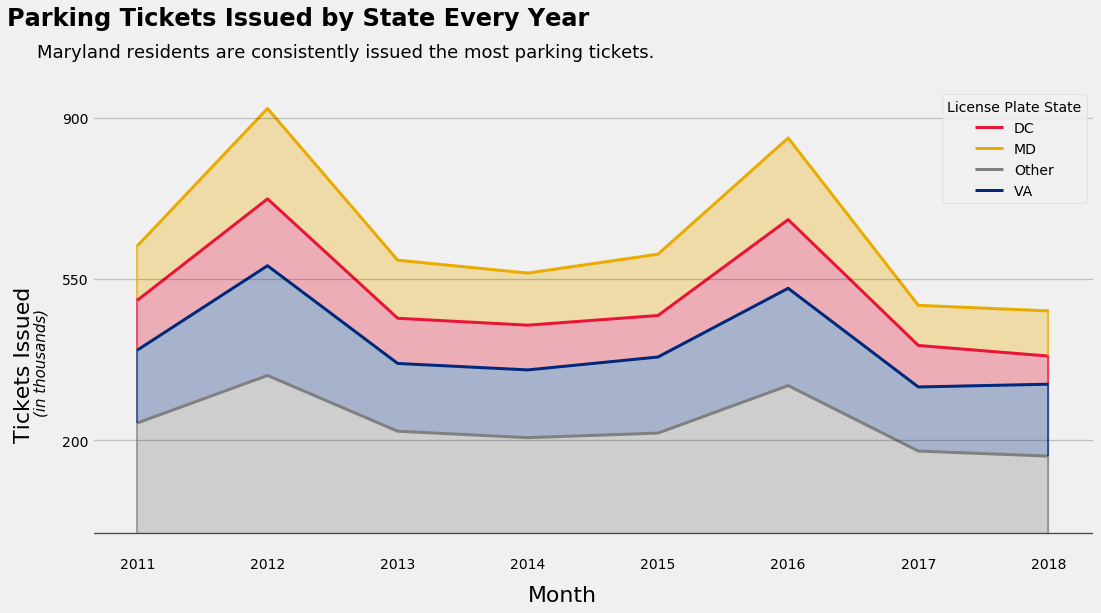

In [38]:
plt.style.use('fivethirtyeight')
                                                                            #DC         #MD     #Other     #VA
ax = tickets_by_year.plot.line(figsize = (16,8), linewidth = 3, color = ('#E91436', '#EAAB00','#808080','#00297B'))

#Fill between based on state plate. 
plt.fill_between(np.arange(0,8), tickets_by_year['MD'],tickets_by_year['DC'],color = '#EAAB00', alpha = .3)
plt.fill_between(np.arange(0,8), tickets_by_year['DC'],tickets_by_year['VA'],color = '#E91436', alpha = .3)
plt.fill_between(np.arange(0,8), tickets_by_year['VA'],tickets_by_year['Other'],color = '#00297B', alpha = .3)
plt.fill_between(np.arange(0,8), tickets_by_year['Other'], [1], color = '#808080' , alpha = .3)

#Replacing my labels. 
ax.set_xticklabels(['','2011', '2012', '2013','2014','2015','2016','2017','2018'])
ax.set_yticks([200, 550 , 900])

#Make my own minimalist grid
ax.grid(False)
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7) # modify to 100 to compress the bottom of the chart more. 
plt.axhline(y = 200, color = 'black', linewidth = 1.3, alpha = .2)  #### Create horizontal lines to 
plt.axhline(y = 550, color = 'black', linewidth = 1.3, alpha = .2)  #### identify values without being crowded. 
plt.axhline(y = 900, color = 'black', linewidth = 1.3, alpha = .2) 

#Vertical lines to close in the left side of the chart. This is aesthetic
plt.axvline(x = 0, ymax = .28 , ymin = 0.045, color = '#808080', linewidth = 2, alpha = .7)
plt.axvline(x = 0, ymax = .44 , ymin = 0.28, color = '#00297B', linewidth = 2, alpha = .7)
plt.axvline(x = 0, ymax = .549 , ymin = 0.44, color = '#E91436', linewidth = 2, alpha = .7)
plt.axvline(x = 0, ymax = .663 , ymin = 0.549, color = '#EAAB00', linewidth = 2, alpha = .7)

#Vertical Line to close in the right side of the chart. 
plt.axvline(x = 7, ymax = .21 , ymin = 0.045, color = '#808080', linewidth = 2, alpha = .7)
plt.axvline(x = 7, ymax = .367 , ymin = 0.21, color = '#00297B', linewidth = 2, alpha = .7)
plt.axvline(x = 7, ymax = .423 , ymin = 0.367, color = '#E91436', linewidth = 2, alpha = .7)
plt.axvline(x = 7, ymax = .525, ymin = 0.423, color = '#EAAB00', linewidth = 2, alpha = .7)

# Text and annotations
plt.text(x = 3 , y = -150, s = 'Month',
        fontsize = 22)
plt.text(x = -.95, y = 500, s = 'Tickets Issued',
        fontsize = 22, rotation = 90,)
plt.text(x = -.8, y = 460, s = '(in thousands)',
        fontsize = 15, rotation = 90, fontstyle = 'italic')
plt.text(x= -1 , y=1100, s = "Parking Tickets Issued by State Every Year",
       fontsize = 24, fontweight = 'bold')
plt.text(x= -.77 , y=1030,s = "Maryland residents are consistently issued the most parking tickets.",
       fontsize = 18)


plt.plot();

In [15]:
total = (round(pd.crosstab(df['License Plate State'], 
                           df['Violation Bins'], 
                           normalize = True)*100, 2)
         [['Obstructing Traffic','ROSA Violation', 'DMV Related Violation',
              'Residential Zone Violation','Temporary Parking Restriction',
              'Illegal Parking Location','Meter Violation']]) # Reorder my columns to something more aestehtically pleasing. 

del total.index.name #Pesky index name getting in the way. 

x_ticks = total.columns.values.tolist() #For x_ticks

total

Violation Bins,Obstructing Traffic,ROSA Violation,DMV Related Violation,Residential Zone Violation,Temporary Parking Restriction,Illegal Parking Location,Meter Violation
DC,1.11,0.01,3.96,2.48,5.90,7.67,7.33
MD,2.09,2.61,1.31,4.40,4.85,8.94,11.57
Other,0.47,1.40,0.71,1.53,2.42,3.08,3.54
VA,0.78,1.26,2.28,2.57,2.96,4.83,7.97


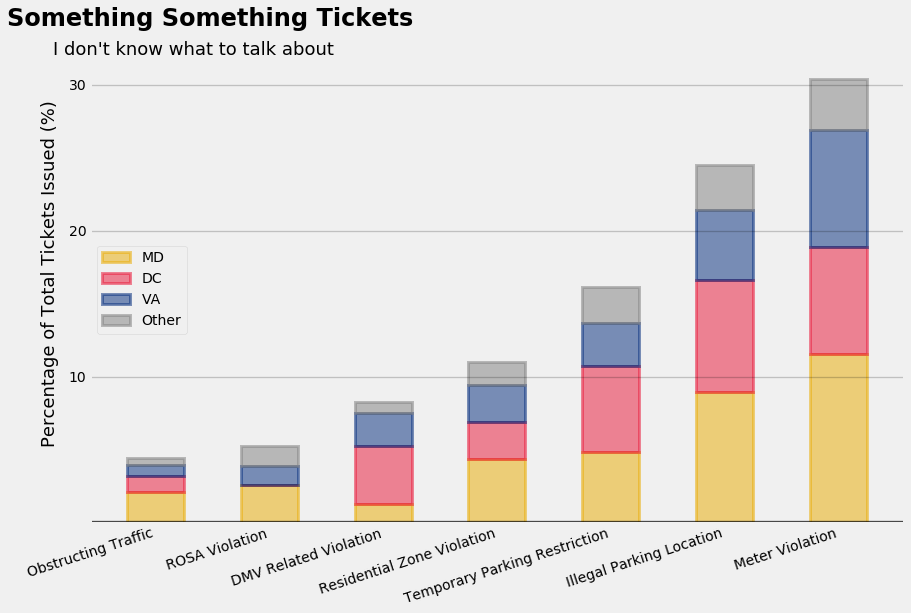

In [16]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(13, 8))

# Defining variables for plottling
ind = np.arange(7)   
width = .5
opacity = .5
linewidth = 3

# 4 Stacks based on State
p1 = plt.bar(ind, total.iloc[1], width, 
             color = '#EAAB00', alpha = opacity,
             edgecolor = '#EAAB00', linewidth = linewidth,
             label = 'MD')
p2 = plt.bar(ind, total.iloc[0], width,
             bottom=total.iloc[1], 
             color = '#E91436', alpha = opacity,
             edgecolor = '#E91436', linewidth = linewidth,
             label = 'DC')
p3 = plt.bar(ind, total.iloc[3], width,
             bottom=total.iloc[1]+total.iloc[0], 
             color = '#00297B' , alpha = opacity,
             edgecolor = '#00297B', linewidth = linewidth,
             label = 'VA')
p4 = plt.bar(ind, total.iloc[2], width,
             bottom=total.iloc[3]+total.iloc[1]+total.iloc[0], 
             color = '#808080', alpha = opacity,
             edgecolor = '#808080', linewidth = linewidth,
             label = 'Other')

# Horizontal lines for reference
plt.axhline(y = .15, color = 'black', linewidth = 1.3, alpha = .7) 
plt.axhline(y = 30, color = 'black', linewidth = 1.3, alpha = .2)  
plt.axhline(y = 20, color = 'black', linewidth = 1.3, alpha = .2)  
plt.axhline(y = 10, color = 'black', linewidth = 1.3, alpha = .2) 

# Text and annotations
#plt.text(x = 2 , y = -8, s = 'Type of Ticket Issued',
        #fontsize = 18)
plt.text(x = -1, y = 28, s = 'Percentage of Total Tickets Issued (%)',
        fontsize = 18, rotation = 90,)
plt.text(x= -1.3 , y=34, s = "Something Something Tickets",
       fontsize = 24, fontweight = 'bold')
plt.text(x= -.9 , y=32,s = "I don't know what to talk about",
       fontsize = 18)

# Ticks and Grid
ax.set_yticks([10,20,30])
plt.xticks(np.arange(7)  ,x_ticks, rotation = 18, ha = 'right')
ax.grid(False)
plt.legend()

plt.show();

In [17]:
congestion = (round(pd.crosstab(df['License Plate State'], 
                                df['Violation Bins'], 
                                normalize = 'columns')*100, 2)  #Isolate my Congestion Columns
             [['Illegal Parking Location', 'Obstructing Traffic','Residential Zone Violation']]).T


"""congestion = (round(pd.crosstab(df['Violation Bins'], 
                                df['License Plate State'], 
                                normalize = 'columns')*100, 2)  #Isolate my Congestion Columns
             [['Illegal Parking Location', 'Obstructing Traffic','Residential Zone Violation']])"""

del congestion.index.name

x_ticks = congestion.index.values.tolist()

congestion

License Plate State,DC,MD,Other,VA
Illegal Parking Location,31.29,36.46,12.55,19.69
Obstructing Traffic,24.82,46.99,10.59,17.60
Residential Zone Violation,22.60,40.09,13.95,23.35


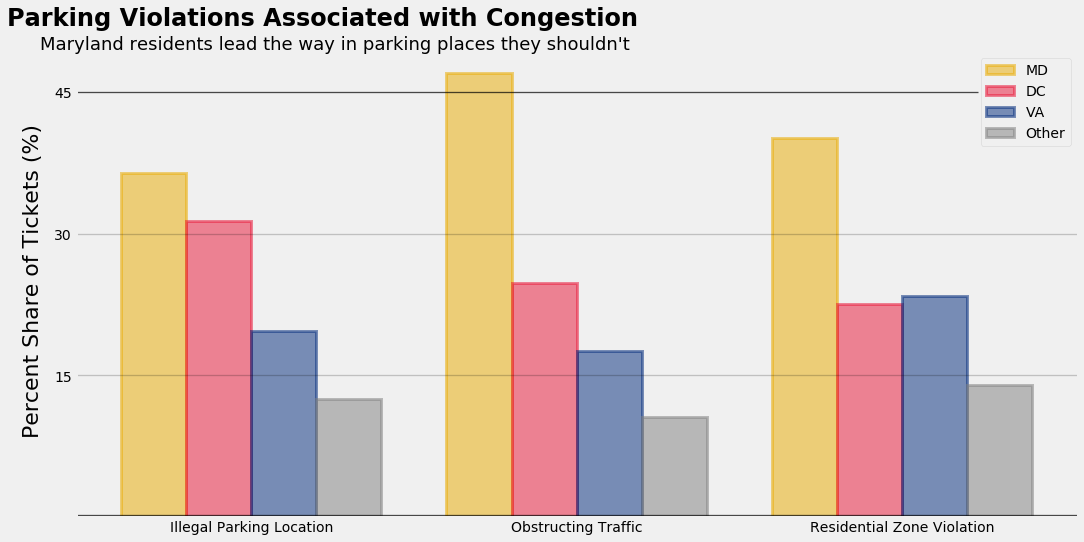

In [18]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(16 , 8))

# Defining variables for plottling
n_groups = congestion['DC'].nunique() 
index = np.arange(n_groups)
width = .2
opacity = .5
linewidth = 3

# My plots, by State
MD = plt.bar(index, congestion['MD'], width, 
             alpha=opacity, color='#EAAB00',
             edgecolor = '#EAAB00', linewidth = linewidth,
             label = 'MD')
DC = plt.bar(index + width, congestion['DC'], width, 
             alpha=opacity, color='#E91436',
             edgecolor = '#E91436', linewidth = linewidth,
             label = 'DC')
VA = plt.bar(index + 2*width, congestion['VA'], width, 
             alpha=opacity, color='#00297B',
             edgecolor = '#00297B', linewidth = linewidth,
             label = 'VA')
Other = plt.bar(index + 3*width, congestion['Other'], width, 
                alpha=opacity, color='#808080',
                edgecolor = '#808080', linewidth = linewidth,
                label = 'Other')

plt.axhline(y = .2, color = 'black', linewidth = 1.3, alpha = .7) 
plt.axhline(y = 45, xmax = .9, color = 'black', linewidth = 1.3, alpha = .7)  
plt.axhline(y = 30, color = 'black', linewidth = 1.3, alpha = .2)  
plt.axhline(y = 15, color = 'black', linewidth = 1.3, alpha = .2) 


plt.text(x = -.4 , y = 40, s = 'Percent Share of Tickets (%)',
        fontsize = 22, rotation = 90,)
ax.text(x=-.45,y=52, s = "Parking Violations Associated with Congestion",
       fontsize = 24, fontweight = 'bold')
ax.text(x= -.35,y=49.5, s = "Maryland residents lead the way in parking places they shouldn't",
       fontsize = 18)


ax.set_yticks([15,30,45])
plt.xticks([.3,1.3,2.3]  , x_ticks )
ax.grid(False)

plt.legend(loc = 1)

plt.show();

In [19]:
(round(pd.crosstab(df['License Plate State'], 
                                df['Violation Bins'], 
                                normalize = 'columns')*100, 2))

Violation Bins,DMV Related Violation,Illegal Parking Location,Meter Violation,Obstructing Traffic,ROSA Violation,Residential Zone Violation,Temporary Parking Restriction
License Plate State,,,,,,,
DC,48.01,31.29,24.11,24.82,0.12,22.60,36.61
MD,15.83,36.46,38.05,46.99,49.52,40.09,30.06
Other,8.56,12.55,11.66,10.59,26.50,13.95,15.01
VA,27.59,19.69,26.19,17.60,23.86,23.35,18.33


In [20]:

md = df.loc[df['License Plate State'] == 'MD']
MDOT = md.loc[md['Violation Bins'] == 'Obstructing Traffic']
MDIP = md.loc[md['Violation Bins'] == 'Illegal Parking Location']


In [21]:
round(pd.crosstab(MDOT['Violation Description'], MDOT['Year'], normalize = 'columns', margins = True)* 100, 1)

Year,2011,2012,2013,2014,2015,2016,2017,2018,All
Violation Description,,,,,,,,,
OBSTRUCTING CROSSWALK,4.6,4.4,4.0,5.0,5.6,6.3,6.9,7.9,5.3
"OBSTRUCTING ENTRANCE OF PKG GARAGE, DOOR OR GATE",1.5,0.8,0.8,0.4,0.3,0.4,0.8,1.1,0.8
OPP OR BESIDE CONTRUCTION SITE OBSTRUCTING TRAFFIC,1.4,0.4,2.7,1.2,0.7,1.1,1.6,1.1,1.2
PARK ABREAST OF ANOTHER VEHICLE,39.6,40.5,37.8,32.1,29.0,22.2,19.3,19.4,32.1
PARK IN A DESIGNATED ENTRANCE,17.0,18.0,16.7,17.8,19.0,18.7,17.3,17.5,17.8
PARK MORE THAN 12 INCHES FROM CURB,1.5,0.7,0.7,0.8,0.9,1.0,1.4,0.8,0.9
PARK TO REDUCE ROADWAY TO LESS THAN 10 FEET,0.5,0.5,0.4,0.5,0.3,0.4,0.4,0.3,0.4
PARKED IN DRIVEWAY OR ALLEY TO OBSTRUCT SIDEWALK,1.6,1.8,1.7,1.8,1.9,2.1,2.2,2.1,1.9
STAND OR PARK IN ALLEY,28.7,28.8,29.2,33.5,34.4,39.7,42.4,43.1,33.6


In [40]:
# Going to focus the crosstab in order to create a more clear chart. 
Obstruct = (round(pd.crosstab(MDOT['Violation Description'], 
                              MDOT['Year'], normalize = 'columns')* 100, 1).T)

low_val = Obstruct.drop(columns = ['PARK ABREAST OF ANOTHER VEHICLE',
                                   'PARK IN A DESIGNATED ENTRANCE',
                                   'STAND OR PARK IN ALLEY'])
big_val = Obstruct[['PARK ABREAST OF ANOTHER VEHICLE',
                    'PARK IN A DESIGNATED ENTRANCE',
                    'STAND OR PARK IN ALLEY']]

# Creating a column of summed values for all the low frequency violations
indexing = np.arange(8)
vals = []

for i in indexing:
    vals.append(low_val.iloc[i].sum())

# New Summed dataframe to join
e_else = pd.DataFrame(vals, 
                      columns = ['EVERYTHING ELSE'], 
                      index = big_val.index.values.tolist())
# Final Dataframe
o_per = big_val.join(e_else)

o_per

,PARK ABREAST OF ANOTHER VEHICLE,PARK IN A DESIGNATED ENTRANCE,STAND OR PARK IN ALLEY,EVERYTHING ELSE
Year,,,,
2011,39.6,17.0,28.7,14.7
2012,40.5,18.0,28.8,12.8
2013,37.8,16.7,29.2,16.3
2014,32.1,17.8,33.5,16.6
2015,29.0,19.0,34.4,17.6
2016,22.2,18.7,39.7,19.3
2017,19.3,17.3,42.4,21.1
2018,19.4,17.5,43.1,19.9


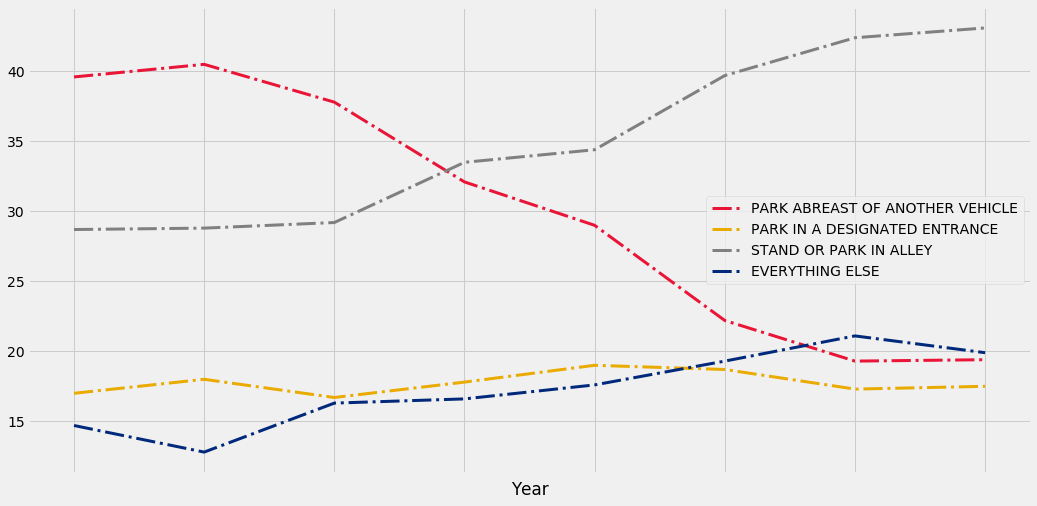

In [43]:
plt.style.use('fivethirtyeight')
                                                               
ax = o_per.plot.line(figsize = (16,8), linewidth = 3,linestyle = '-.', color = ('#E91436', '#EAAB00','#808080','#00297B'))

In [24]:
# Going to focus the crosstab in order to create a more clear chart. 
Obstruct = ((pd.crosstab(MDOT['Violation Description'], 
                              MDOT['Year'])).T)

low_val = Obstruct.drop(columns = ['PARK ABREAST OF ANOTHER VEHICLE',
                                   'PARK IN A DESIGNATED ENTRANCE',
                                   'STAND OR PARK IN ALLEY'])
big_val = Obstruct[['PARK ABREAST OF ANOTHER VEHICLE',
                    'PARK IN A DESIGNATED ENTRANCE',
                    'STAND OR PARK IN ALLEY']]

# Creating a column of summed values for all the low frequency violations
indexing = np.arange(8)
vals = []

for i in indexing:
    vals.append(low_val.iloc[i].sum())

# New Summed dataframe to join
e_else = pd.DataFrame(vals, 
                      columns = ['EVERYTHING ELSE'], 
                      index = big_val.index.values.tolist())
# Final Dataframe
o_per = big_val.join(e_else)

o_per

,PARK ABREAST OF ANOTHER VEHICLE,PARK IN A DESIGNATED ENTRANCE,STAND OR PARK IN ALLEY,EVERYTHING ELSE
Year,,,,
2011,16748,7189,12123,6225
2012,25764,11462,18291,8074
2013,15082,6650,11666,6510
2014,11208,6195,11695,5781
2015,9760,6392,11559,5906
2016,9759,8232,17416,8503
2017,4552,4084,9999,4969
2018,3669,3307,8134,3755


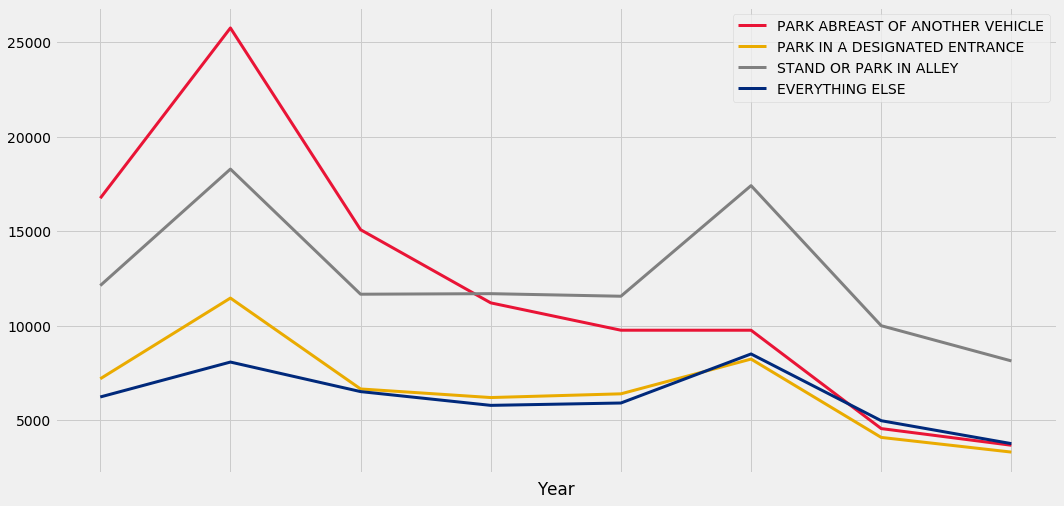

In [25]:
plt.style.use('fivethirtyeight')
                                                               
ax = o_per.plot.line(figsize = (16,8), linewidth = 3, color = ('#E91436', '#EAAB00','#808080','#00297B'))

Start with Totals, then show downward trend in double parking compared to blocking an alley. 

In [26]:
round(pd.crosstab(MDIP['Violation Description'], MDIP['Year'], normalize = 'columns', margins = True)* 100, 1)

Year,2011,2012,2013,2014,2015,2016,2017,2018,All
Violation Description,,,,,,,,,
ABANDON VEHICLE ON PUBLIC/PRIVATE PROPERTY VIOL 1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
COMMERCIAL MOTOR VEHICLE - NOT OUT OF SERVICE,0.1,0.0,0.2,0.3,0.1,0.2,0.3,0.3,0.2
DANGEROUS VEHICLE ON PRIV/PUBLIC PROP VIOL 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DISOBEYING OFFICIAL SIGN,13.1,20.6,34.7,32.4,29.7,30.4,29.3,29.0,27.3
FAIL TO PARK PARALLEL,0.1,0.2,0.1,0.0,0.1,0.1,0.1,0.1,0.1
GOVERNMENT VEHICLE PARKING ONLY,0.5,0.5,0.3,0.4,0.6,0.6,0.6,0.7,0.5
MOTOR RUNNING UNATTENDED,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
NO PARKING ANYTIME,20.8,18.3,16.0,16.6,15.0,15.3,15.5,15.8,16.6
NO STANDING ANYTIME,15.3,14.4,12.6,11.5,11.3,10.2,11.0,11.9,12.2


Finish with Violation Distribution by month. Lead into the next blog post. 

In [27]:
round(pd.crosstab(md['Violation Bins'], md['Month'], normalize = 'columns')*100, 1)

Month,1,2,3,4,5,6,7,8,9,10,11,12
Violation Bins,,,,,,,,,,,,
DMV Related Violation,3.7,3.4,3.1,3.4,3.5,3.6,3.7,3.7,3.9,3.9,4.0,4.0
Illegal Parking Location,25.7,25.0,23.6,24.7,24.8,24.7,25.0,23.8,25.5,24.8,26.0,26.7
Meter Violation,32.7,34.6,34.5,32.1,31.9,31.3,31.3,32.0,31.9,31.8,33.0,31.2
Obstructing Traffic,6.2,6.3,5.9,6.0,5.9,5.7,5.6,5.6,5.6,5.4,5.9,6.2
ROSA Violation,7.5,7.2,6.8,6.4,6.6,7.1,7.4,7.4,7.3,7.9,8.0,8.3
Residential Zone Violation,13.8,14.2,12.9,11.9,11.7,11.5,11.2,11.7,11.3,11.8,13.3,12.7
Temporary Parking Restriction,10.3,9.3,13.1,15.5,15.5,16.0,15.8,15.7,14.6,14.4,9.8,10.9
